In [78]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cv2 as cv
import random as rng
from math import ceil

print(cv.__version__) 

4.11.0


# Functions used

In [79]:
def findDice(image, show_figures=False):
    # Description: Find the dice in the image and return their bounding boxes.
    # Input: image - the image to process
    # Output: dice_rects - a list of bounding boxes for the dice found in the image.

    img_orig = image.copy() # Create a copy of the original image

    # Grayscale the image
    img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)
    # Blurring the image
    img_blur = cv.blur(img_gray, (3,3))
    # Detect edges using Canny
    threshold = 200 # Threshold for Canny edge detection
    canny_output = cv.Canny(img_blur, threshold, threshold * 2)
    # Find Contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw Contours
    img_contours = image.copy()# np.zeros(img_orig.shape, np.uint8)

    dice_rects = [] # List to hold the bounding boxes of the dice found
    for contour in contours:
        # Approximate the contour to a polygon, this reduces the number of points in the contour
        # and makes it easier to fit a bounding rectangle.
        epsilon = 0.01*cv.arcLength(contour, True)
        approx_poly = cv.approxPolyDP(contour, epsilon, True)
        # Fitting/Bounding Rectangle
        rect = cv.minAreaRect(approx_poly)
        box = cv.boxPoints(rect)
        box = np.astype(box, int)
        # Box Area and Perimeter
        box_area = cv.contourArea(box)
        # Filter box by area add to dice_rects then draw the boxes
        if (box_area > 800 and box_area < 1500):
            dice_rects.append(np.astype(box, int))
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv.drawContours(img_contours, [box], 0, color, 3, cv.LINE_8, hierarchy, 0)

    return dice_rects

def remove_similar_rects(rect_coords):
    # Description: This function removes similar rectangles from a list of rectangles based on their centers.
    # Input: rect_coords - a list of rectangles to process
    # Output: new_rects - a list of rectangles with similar ones removed.

    # Check if the input list is empty
    if len(rect_coords) == 0:
        return []
    
    # Convert the list of rectangles to a numpy array for easier manipulation
    rect_coords = np.array(rect_coords)
    # Calculate the center of each rectangle
    rect_centers = np.mean(rect_coords, axis=1)

    new_rects = [] # List to hold the new rectangles after removing similar ones
    min_squared_distance = 100 # Minimum squared distance to consider rectangles as similar
    mask = np.arange(len(rect_coords)) # Create a mask to keep track of which rectangles to keep
    # Iterate through the rectangles and check the distance to other rectangles
    for i, center in enumerate(rect_centers[:-1]):
        # Calculate the squared distance to all other rectangles
        sqaured_distance_to_other_dice = (rect_centers[i+1:,0]-center[0])**2 + (rect_centers[i+1:,1]-center[1])**2
        # If the minimum distance to other rectangles is greater than the threshold, keep this rectangle
        if np.min(sqaured_distance_to_other_dice) > min_squared_distance:
            new_rects.append(rect_coords[i])
    # Always keep the last rectangle
    new_rects.append(rect_coords[-1])
    
    return new_rects

def remove_similar_circs(circ_coords):
    # Description: This function removes similar circles from a list of circles based on their centers.
    # Input: circ_coords - a list of circles to process
    # Output: new_dots - a list of circles with similar ones removed.

    if len(circ_coords) == 0:
        return []
    
    # Convert the list of circles to a numpy array for easier manipulation
    circ_coords = np.array(circ_coords)
    # extract the center of each circle
    centers = circ_coords[:,0:2]
    
    new_dots = [] # List to hold the new circles after removing similar ones
    min_distance = 8 # Minimum distance to consider circles as similar
    mask = np.arange(len(circ_coords)) # Create a mask to keep track of which circles to keep
    for i, center in enumerate(centers[:-1]):
        # Calculate the squared distance to all other circles
        sqaured_distance_to_other_dice = (centers[i+1:,0]-center[0])**2 + (centers[i+1:,1]-center[1])**2
        # If the minimum distance to other circles is greater than the threshold, keep this circle
        if np.min(sqaured_distance_to_other_dice) > min_distance:
            new_dots.append(circ_coords[i])
    # Always keep the last circle
    new_dots.append(circ_coords[-1])
    
    return new_dots

def crop_box(img, coords):
    # Description: Crop the image to the bounding box defined by coords.
    # Input: img - the image to crop, coords - the coordinates of the bounding box
    # Output: cropped image

    x,y,w,h = cv.boundingRect(coords)
    return img[y:y+h, x:x+w]

def find_dots(img, show_figures=False):
    # Description: Find the dots in the image and return their coordinates.
    # Input: img - the image to process
    # Output: dots_coords - a list of coordinates for the dots found in the image.

    img_copy = img.copy() # Create a copy of the original image
    # Grayscale the image
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Blurring the image
    img_blur = cv.blur(img_gray, (1,1))
    # Detect edges using Canny
    threshold = 200
    canny_output = cv.Canny(img_blur, threshold, threshold * 2)
    # Find Contours
    contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Draw Contours
    img_contours = np.zeros(img.shape, np.uint8)

    dots_coords = []
    for contour in contours:
        # Approximate the contour to a polygon, this reduces the number of points in the contour
        # and makes it easier to fit a bounding circle.
        epsilon = 0.01*cv.arcLength(contour, True)
        approx_poly = cv.approxPolyDP(contour, epsilon, True)
        # Fit a bounding circle
        (x, y), radius = cv.minEnclosingCircle(contour)
        fitted_circ_area = np.pi * (radius**2)
        # Area of the contour
        area = cv.contourArea(approx_poly)
        
        min_radius = 3 # Minimum radius of the circle to consider it a dot
        max_radius = 7 # Maximum radius of the circle to consider it a dot
        min_area = min_radius**2 * np.pi
        max_area = max_radius**2 * np.pi
        if (radius > min_radius and radius < max_radius) and (area > min_area and area < max_area):
            dots_coords.append([x, y, radius])  # Append the coordinates of the dot
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv.drawContours(img_copy, [approx_poly], 0, color, 1, cv.LINE_8, hierarchy, 0)

    # Plotting the original image and the dots found
    if show_figures:
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(img_copy)
        plt.axis('off')

        plt.show()
    
    return dots_coords

def showImg(img):
    # Description: Display the image using matplotlib.
    # Input: img - the image to display
    # Output: None

    plt.imshow(img)
    plt.axis('off')
    plt.show()

def draw_rectangles(img, rects, color=(255,0,0)):
    # Description: Draw rectangles on the image.
    # Input: img - the image to draw on, rects - a list of rectangles to draw, color - the color of the rectangles
    # Output: img - the image with the rectangles drawn on it.

    img = img.copy()
    if color=='random':
        for rect in rects:
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv.drawContours(img, [rect], 0, color, 5)
    else:
        for rect in rects:
            cv.drawContours(img, [rect], 0, color, 5)

    return img

def count_dice(image, show_figure = False):
    img = cv.cvtColor(image.copy(), cv.COLOR_RGB2BGR)
    img_scale = image.shape[0] / 2048
    
    box_coords = findDice(img, show_figures=True)

    dice_coords = remove_similar_rects(box_coords)
    img_dice = draw_rectangles(img, dice_coords, color=(255,0,0))
    num_of_dice = len(dice_coords)

    dots_found = []
    for die_coords in dice_coords:
        die = crop_box(img, die_coords)

        dots_coords = find_dots(die, show_figures=False)
        dots_coords = remove_similar_circs(dots_coords)

        num_of_dots = len(dots_coords)
        dots_found.append(num_of_dots)

        if show_figure:
            cv.putText(img_dice, f'{num_of_dots}', die_coords[1], cv.FONT_HERSHEY_SIMPLEX, round(3*img_scale), (0,0,0), round(15*img_scale), cv.LINE_AA)
            cv.putText(img_dice, f'{num_of_dots}', die_coords[1], cv.FONT_HERSHEY_SIMPLEX, round(3*img_scale), (255,255,0), round(3*img_scale), cv.LINE_AA)

    if show_figure:
        cv.putText(img_dice, f'Dice:{num_of_dice}', (0,image.shape[1]), cv.FONT_HERSHEY_SIMPLEX, round(3*img_scale), (0,0,0), round(15*img_scale), cv.LINE_AA)
        cv.putText(img_dice, f'Dice:{num_of_dice}', (0,image.shape[1]), cv.FONT_HERSHEY_SIMPLEX, round(3*img_scale), (255,255,0), round(3*img_scale), cv.LINE_AA)
        showImg(img_dice)

    if dots_found == []:
        print('empty')
    return dots_found

# Result on a sample image

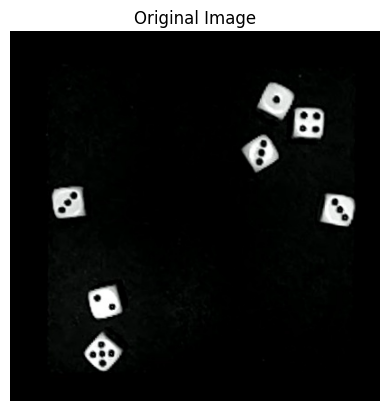

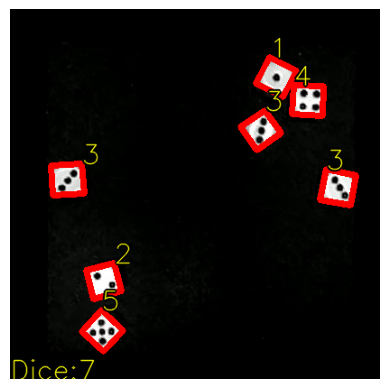

[5, 2, 3, 3, 3, 4, 1]


In [80]:
image = cv.imread(f'photos/test-images/dice (5).jpg')

plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

print(count_dice(image, show_figure=True))

# Creating the distributions and histogram

In [81]:
data = []
for i in range(1, 11000):
    img = cv.imread(f'photos/test-images/Dice ({i}).jpg')
    data = data + count_dice(img)

Number 1 Die Count: 12207
Number 2 Die Count: 12145
Number 3 Die Count: 12040
Number 4 Die Count: 12142
Number 5 Die Count: 12675
Number 6 Die Count: 12169
Classification Error: 18
Total number of dice: 73396


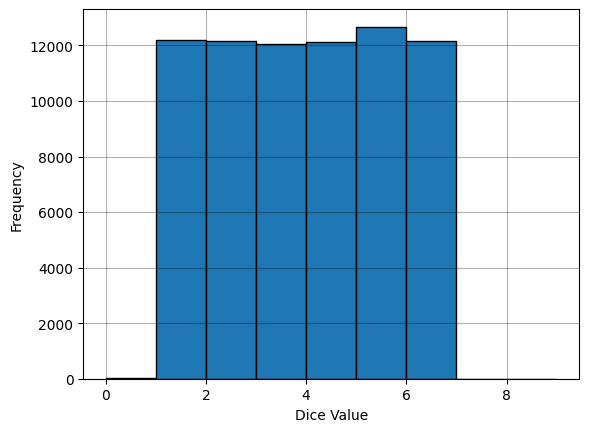

In [82]:
# Classify the number of dots found on each die and count the errors
classified = 0
for i in range(1,7):
    count = data.count(i)
    classified += count
    print(f'Number {i} Die Count: {count}')
error = len(data)-classified

# Print the classification error and the total number of dice found
print(f'Classification Error: {error}')
print('Total number of dice:', len(data))

# Plotting the histogram of the number of dots found on each die
plt.hist(data, edgecolor='black', bins=np.arange(0,10))
plt.xlabel("Dice Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3, color='black')
plt.show()

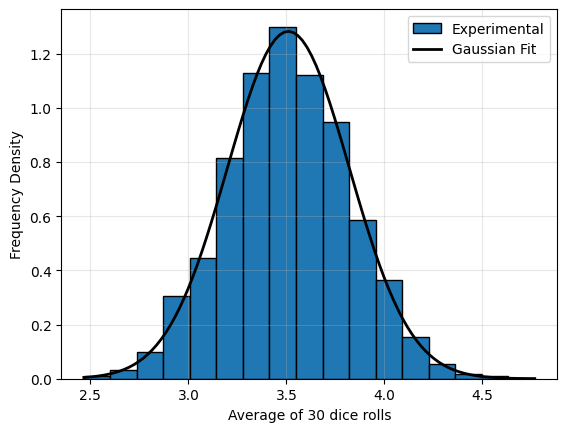

In [94]:
# Number of dice to group together for averaging
dice_per_group = 30
# Group the data into groups of dice_per_group and calculate the average for each group
data_grouped = (np.array(data)[0:len(data)-len(data)%dice_per_group]).reshape((len(data)//dice_per_group, dice_per_group))
ave = np.array([np.mean(x) for x in data_grouped])

# Gaussian Dist
def gauss(x, sigma, mu):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x-mu)/sigma)**2)

# Calculate the Gaussian fit for the average values
x = np.linspace(np.min(ave), np.max(ave), 100)
mean = np.mean(ave)
sigma = np.std(ave)
gaussian = gauss(x, sigma, mean)

# Plotting the histogram of the average values and the Gaussian fit
plt.hist(ave, edgecolor='black', bins=17, density=True, label='Experimental')
plt.plot(x, gaussian, color='black', lw=2, label='Gaussian Fit')
plt.grid(alpha=0.3)
plt.xlabel(f"Average of {dice_per_group} dice rolls")
plt.ylabel("Frequency Density")
plt.legend()
plt.show()